# Case Scenario: Evaluating the Effects of Solarization on Power Quality and Reliability in Bonthe Government Hospital

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import seaborn as sns
import scipy.stats as stats

### 1. Examining SAIDI and SAIFI metrics

#### Prepare Data

In [2]:
# Define function wrangle SAIDI and SAIFI datasets
def wrangle(filepath):
    
    #Read csv file
    df = pd.read_csv(filepath, index_col=0)
    
    #drop 'site_id' column
    df.drop(columns="site_id", inplace=True)
    
    #Convert index to datetime
    df.index = pd.to_datetime(df.index)
    
    #localize timestamp to Africa/Sierra Leone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Freetown")
    
    return df    

In [3]:
# Use wrangle function to import SAIFI and SAIDI datasets 
df_SAIFI = wrangle("data/sierra-leone_saifi_site_id_hour_2023-10-01-to-2024-05-01.csv")
df_SAIDI = wrangle("data/sierra-leone_saidi_site_id_hour_2023-10-01-to-2024-05-01.csv")

print(df_SAIFI.head())
print()
print(df_SAIFI.shape)

print()

print(df_SAIDI.head())
print()
print(df_SAIDI.shape)

                           SAIFI
hour                            
2023-10-01 00:00:00+00:00    0.0
2023-10-01 01:00:00+00:00    0.0
2023-10-01 02:00:00+00:00    0.0
2023-10-01 03:00:00+00:00    0.0
2023-10-01 04:00:00+00:00    0.0

(5112, 1)

                           SAIDI
hour                            
2023-10-01 00:00:00+00:00   0.75
2023-10-01 01:00:00+00:00   0.75
2023-10-01 02:00:00+00:00   0.75
2023-10-01 03:00:00+00:00   0.75
2023-10-01 04:00:00+00:00   0.80

(5112, 1)


In [4]:
# Concatenate SAIFI and SAIDI datasets
df=pd.concat([df_SAIFI, df_SAIDI], axis=1)
df.shape

(5112, 2)

In [5]:
# Check dataset. Should return an error if tests fail 

assert isinstance(df, pd.DataFrame)
assert isinstance(df.index, pd.DatetimeIndex)
assert df.index.tzinfo == pytz.timezone("Africa/Freetown")

#### Explore

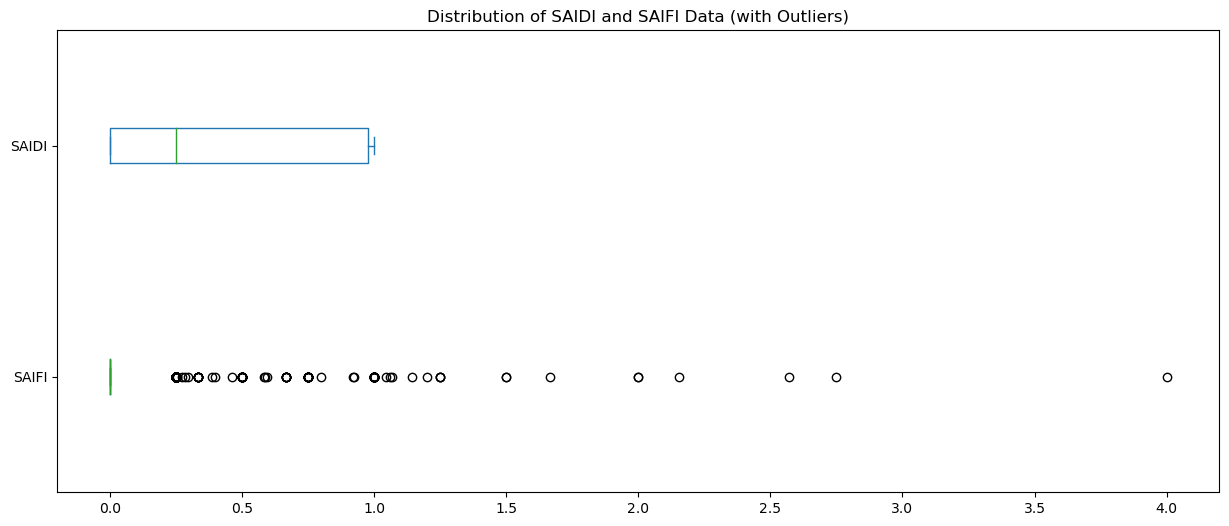

In [6]:
#Create a boxplot to visualize the distribution of the data (with possible outliers)
fig, ax = plt.subplots(figsize=(15, 6))
df[["SAIFI", "SAIDI"]].plot(
    kind="box",
    vert=False,
    title="Distribution of SAIDI and SAIFI Data (with Outliers)",
    ax=ax);

In [7]:
# Generate descriptive statistics of SAIFI and SAIDI data

print(df["SAIFI"].describe())

print()

print(df["SAIDI"].describe())

count    5112.000000
mean        0.028579
std         0.157144
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         4.000000
Name: SAIFI, dtype: float64

count    5112.000000
mean        0.393591
std         0.402833
min         0.000000
25%         0.000000
50%         0.250000
75%         0.977032
max         1.000000
Name: SAIDI, dtype: float64


Both SAIDI and SAIFI data have very high spread, pointing to the existence of outliers. 
For example, the maximum value in SAIFI in 4, while, at the same time, 75% of data points that 
lie below the 75th percentile are less than 0.00000.

We need to remove any outliers. 

One way is by applying a quantile mask, which was abandoned as it removes a lot of data that does not meet a 
defined criteria. Instead, used mean and standard deviation to remove the outliers.

In [8]:
'''#Remove outliers using a quantile mask
low,high= df["SAIFI"].quantile([0.1, 0.95])
mask_saifi=df["SAIFI"].between(low,high)
df=df[mask_saifi]
df["SAIFI"].describe()'''

'#Remove outliers using a quantile mask\nlow,high= df["SAIFI"].quantile([0.1, 0.95])\nmask_saifi=df["SAIFI"].between(low,high)\ndf=df[mask_saifi]\ndf["SAIFI"].describe()'

In [9]:
 #Use mean and standard deviation to remove outliers
mean = df["SAIFI"].mean()
std = df["SAIFI"].std()

cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off
df = df[(df["SAIFI"] < upper) & (df["SAIFI"] > lower)]

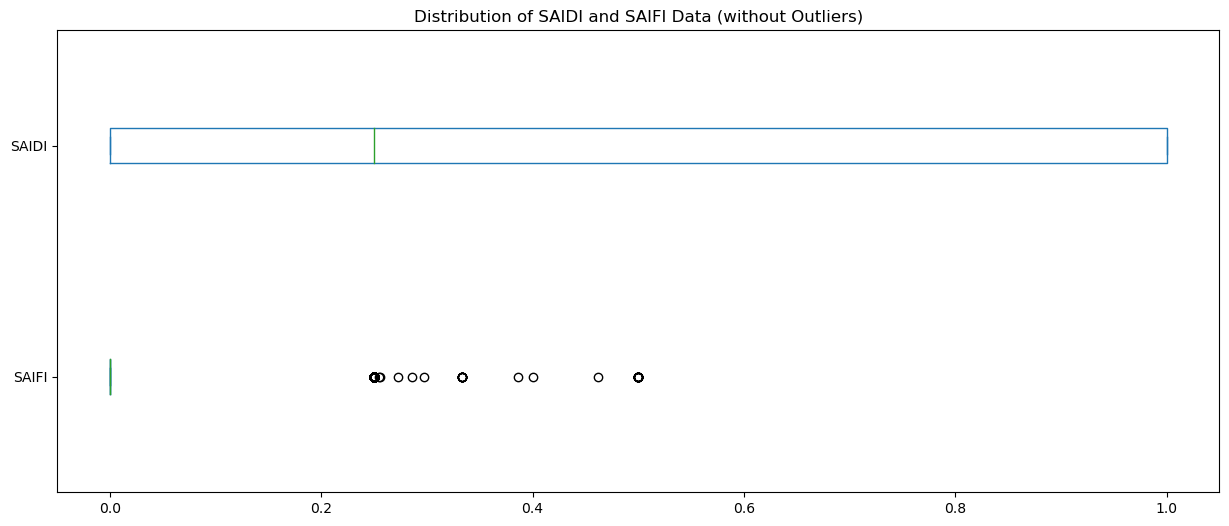

In [10]:
#Create a boxplot to visualize the distribution of the data without outliers
fig, ax = plt.subplots(figsize=(15, 6))
df[["SAIFI", "SAIDI"]].plot(
    kind="box",
    vert=False,
    title="Distribution of SAIDI and SAIFI Data (without Outliers)",
    ax=ax);

In [11]:
# Check descriptive statistics of SAIFI and SAIDI data

print(df["SAIFI"].describe())

print()

print(df["SAIDI"].describe())

count    5029.000000
mean        0.011754
std         0.058490
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.500000
Name: SAIFI, dtype: float64

count    5029.000000
mean        0.391239
std         0.404226
min         0.000000
25%         0.000000
50%         0.250000
75%         1.000000
max         1.000000
Name: SAIDI, dtype: float64


#### Visualizing the Data

- We will use a time series plot to help identify any patterns in the data. 
- The data is collected and recorded in the dataset in one hour intervals, which results in 
a lot of data points when examined in totality. We, therefore, need to resample the data 
into a more manageable interval of readings. 
    

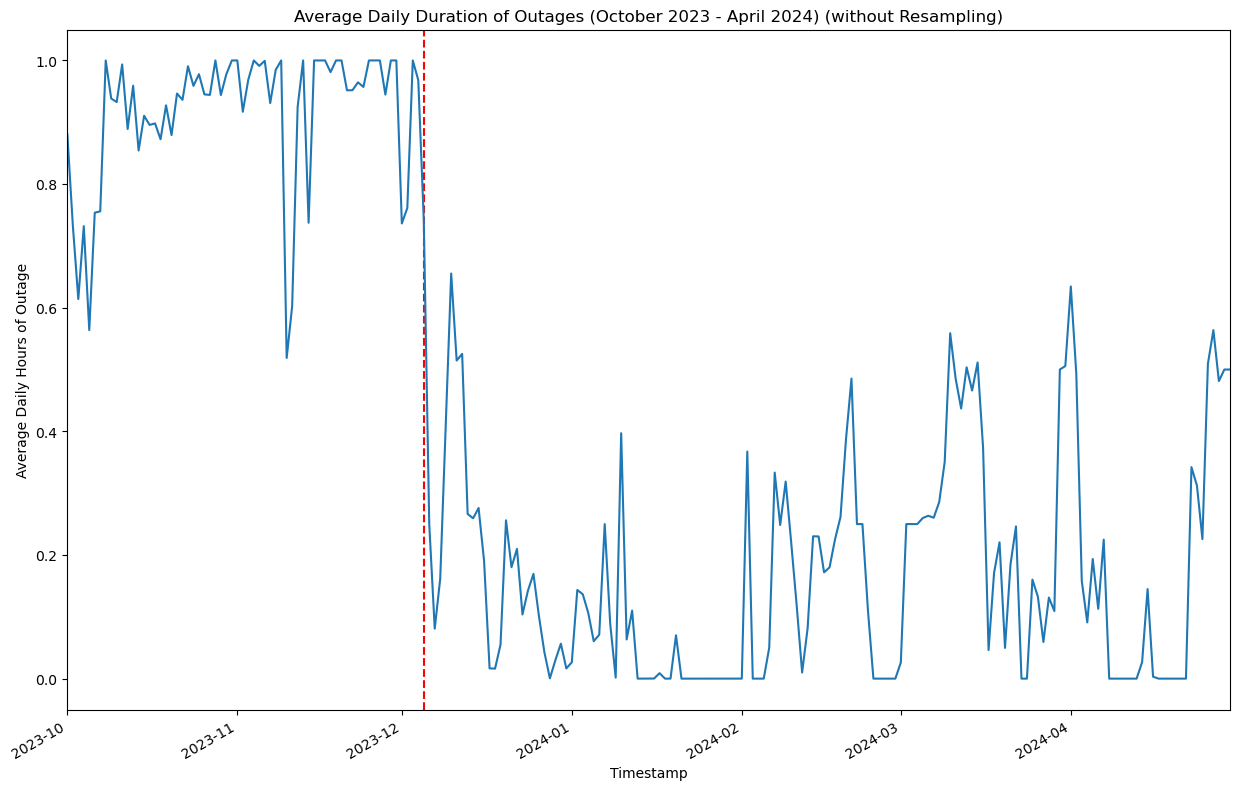

In [15]:
# Plot SAIDI timeseries plot without resampling data

fig, ax = plt.subplots(figsize = (15,10))

ax.axvline(
    pd.Timestamp('2023-12-05'), 
    color='red', 
    linestyle='--', 
    label='Solar Installation'
)

#Set x-axis limits to the range of the data
ax.set_xlim(df.index.min(), df.index.max())

df["SAIDI"].plot(
    xlabel="Timestamp", 
    ylabel="Average Daily Hours of Outage", 
    title="Average Daily Duration of Outages (October 2023 - April 2024) (without Resampling)",
    ax=ax);

In [13]:
# Resample data to daily time periods

df = df[["SAIFI", "SAIDI"]].resample("1D").mean()

In [14]:
#Check for any missing values (impute using ffill if any)

df[["SAIFI", "SAIDI"]].resample("1D").mean().isnull().sum()

SAIFI    0
SAIDI    0
dtype: int64

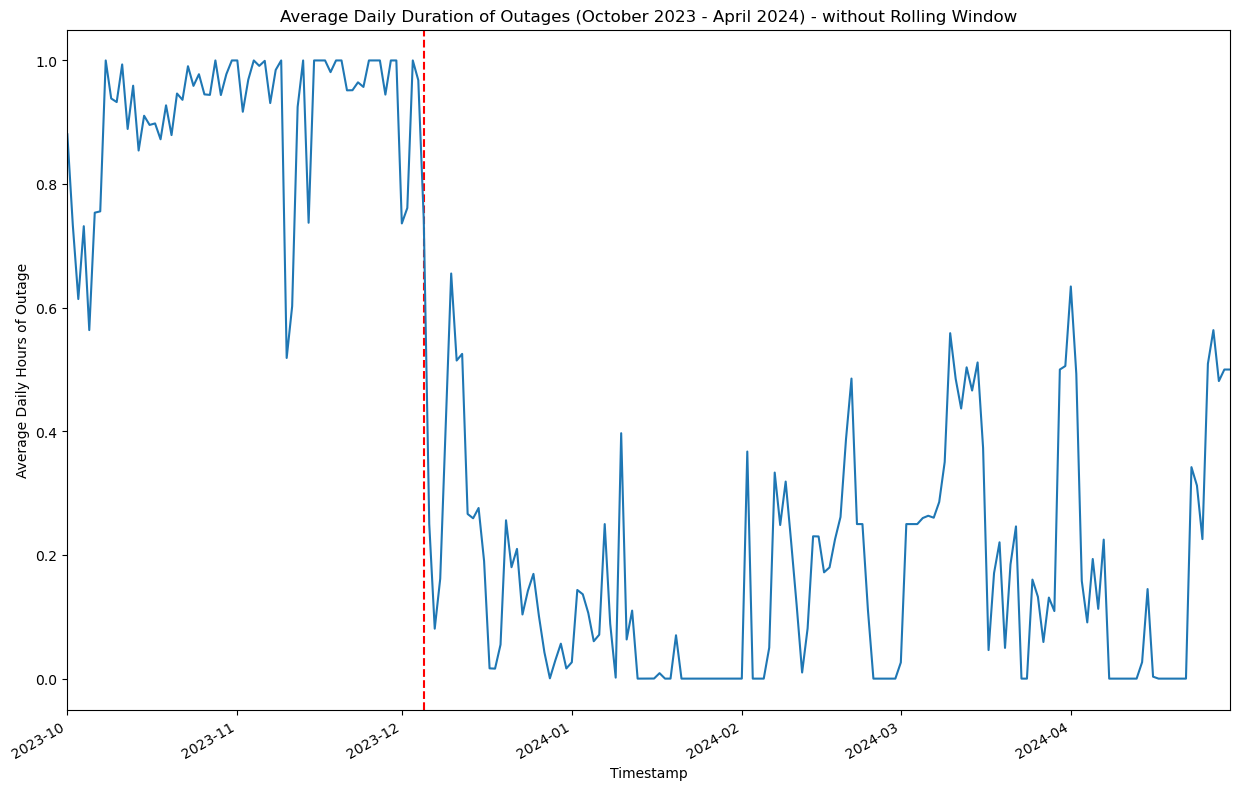

In [16]:
# Plot SAIDI timeseries plot with resampled data

fig, ax = plt.subplots(figsize = (15,10))

ax.axvline(
    pd.Timestamp('2023-12-05'), 
    color='red', 
    linestyle='--', 
    label='Solar Installation'
)

#Set x-axis limits to the range of the data
ax.set_xlim(df.index.min(), df.index.max())

df["SAIDI"].plot(
    xlabel="Timestamp", 
    ylabel="Average Daily Hours of Outage", 
    title="Average Daily Duration of Outages (October 2023 - April 2024) - without Rolling Window",
    ax=ax);

The plot above is choppy - we need to smoothen it to clearly see the underlying pattern. We achieve 
this by applying a rolling window of size 12 (12 hours)

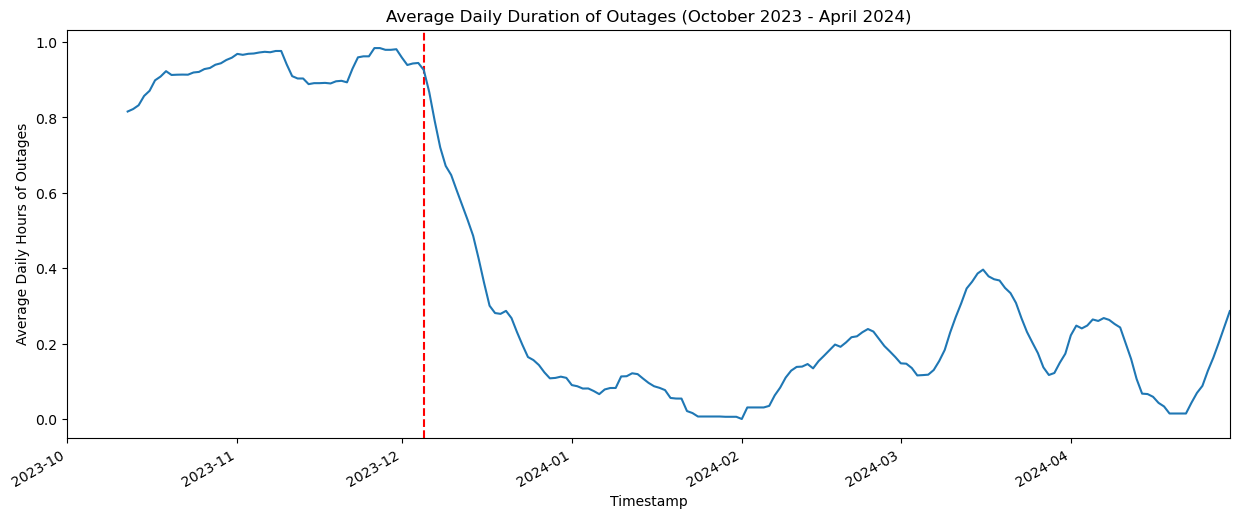

In [17]:
fig, ax = plt.subplots(figsize=(15, 6))


ax.set_xlim(df.index.min(), df.index.max())

ax.axvline(
    pd.Timestamp('2023-12-05'), 
    color='red', 
    linestyle='--', 
    label='Solar Installation')

df["SAIDI"].rolling(12).mean().plot(
    xlabel="Timestamp", 
    ylabel="Average Daily Hours of Outages", 
    title="Average Daily Duration of Outages (October 2023 - April 2024)",
    ax=ax);


plt.savefig("images/SAIDI-time-series-with-rolling-average.png", dpi=150)

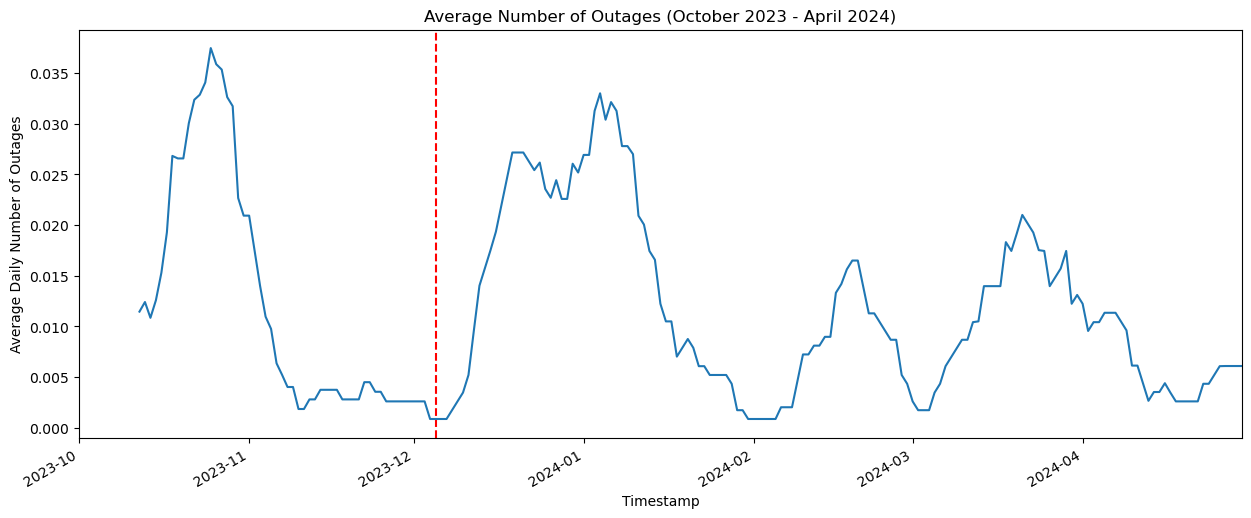

In [18]:
# Plot SAIFI time series with resampled data and with rolling average

fig, ax = plt.subplots(figsize=(15, 6))


ax.set_xlim(df.index.min(), df.index.max())

ax.axvline(
    pd.Timestamp('2023-12-05'), 
    color='red', 
    linestyle='--', 
    label='Solar Installation')

df["SAIFI"].rolling(12).mean().plot(
    xlabel="Timestamp", 
    ylabel="Average Daily Number of Outages", 
    title="Average Number of Outages (October 2023 - April 2024)",
    ax=ax);


plt.savefig("images/SAIFI-time-series-with-rolling-average.png", dpi=150)

From the SAIDI and SAIFI plots above, we see a noticeable drop in SAIDI post the installation 
date, but not in SAIFI. We can test these metrics statistically to confirm the observations. 

##### Testing Statistical Significance of Differences in PQR Metrics

To statistically test the significance of differences in PQR metrics pre and post-installation, we can use the t-test for normally distributed data and the Mann-Whitney U test for non-normally distributed data.

1. Normality Check

In [19]:
# Separate pre- and post-solarization data
installation_date = '2023-12-05'
df_pre = df[df.index < installation_date]
df_post = df[df.index >= installation_date]

In [20]:
print(df_post.shape)

print()

print(df_pre.shape)

(148, 2)

(65, 2)


We will use the Shapiro-Wilk test to check if the data is normally distributed.


In [21]:
# Shapiro-Wilk test for normality

#SAIDI
saidi_pre_shapiro = stats.shapiro(df_pre['SAIDI'])
saidi_post_shapiro = stats.shapiro(df_post['SAIDI'])

#SAIFI
saifi_pre_shapiro = stats.shapiro(df_pre['SAIFI'])
saifi_post_shapiro = stats.shapiro(df_post['SAIFI'])

print(f"SAIDI Pre-installation Shapiro-Wilk test: statistic={saidi_pre_shapiro.statistic}, p-value={saidi_pre_shapiro.pvalue}")
print(f"SAIDI Post-installation Shapiro-Wilk test: statistic={saidi_post_shapiro.statistic}, p-value={saidi_post_shapiro.pvalue}")
print(f"SAIFI Pre-installation Shapiro-Wilk test: statistic={saifi_pre_shapiro.statistic}, p-value={saifi_pre_shapiro.pvalue}")
print(f"SAIFI Post-installation Shapiro-Wilk test: statistic={saifi_post_shapiro.statistic}, p-value={saifi_post_shapiro.pvalue}")


SAIDI Pre-installation Shapiro-Wilk test: statistic=0.7360141277313232, p-value=1.737593624540068e-09
SAIDI Post-installation Shapiro-Wilk test: statistic=0.8588442802429199, p-value=1.3557888145498964e-10
SAIFI Pre-installation Shapiro-Wilk test: statistic=0.6523280143737793, p-value=3.918498164834361e-11
SAIFI Post-installation Shapiro-Wilk test: statistic=0.7623076438903809, p-value=3.315053513273068e-14


To interpret the results of the Shapiro-Wilk test, we focus on the p-values associated with each test. The Shapiro-Wilk test checks the null hypothesis that the data was drawn from a normal distribution.

Interpretation of Shapiro-Wilk Test Results:

- Null Hypothesis (H0): The data is normally distributed.
- Alternative Hypothesis (H1): The data is not normally distributed.
If the p-value is less than a chosen alpha level (commonly 0.05), we reject the null hypothesis and conclude that the data is not normally distributed.

From the results:

- SAIDI Pre-installation:

Statistic: 0.7360141277313232
p-value: 1.737593624540068e-09


- SAIDI Post-installation:

Statistic: 0.8588442802429199
p-value: 1.3557888145498964e-10


- SAIFI Pre-installation:

Statistic: 0.6523280143737793
p-value: 3.918498164834361e-11


- SAIFI Post-installation:

Statistic: 0.7623076438903809
p-value: 3.315053513273068e-14


#### Interpretation:
All p-values are significantly less than 0.05, indicating that we reject the null hypothesis for all tests. This means that none of the data (SAIDI and SAIFI, both pre- and post-installation) is normally distributed.

Statistical Tests to Use:
Since the data is not normally distributed, we should use non-parametric tests. Specifically, we use the Mann-Whitney U test for comparing the distributions pre- and post-installation.

In [22]:
# Mann-Whitney U tests to compare distributions pre and post-installation

#SAIDI
saidi_mannwhitney = stats.mannwhitneyu(df_pre['SAIDI'], df_post['SAIDI'], alternative='two-sided')

#SAIFI
saifi_mannwhitney = stats.mannwhitneyu(df_pre['SAIFI'], df_post['SAIFI'], alternative='two-sided')

print(f"SAIDI Mann-Whitney U test: statistic={saidi_mannwhitney.statistic}, p-value={saidi_mannwhitney.pvalue}")
print(f"SAIFI Mann-Whitney U test: statistic={saifi_mannwhitney.statistic}, p-value={saifi_mannwhitney.pvalue}")

SAIDI Mann-Whitney U test: statistic=9601.0, p-value=4.239756466023046e-31
SAIFI Mann-Whitney U test: statistic=4475.5, p-value=0.38729564528982263


The Mann-Whitney U test checks the null hypothesis that the distributions of the two samples (pre- and post-installation) are identical.

Interpretation of Mann-Whitney U Test Results:

- Null Hypothesis (H0): The distributions of the two samples (pre- and post-installation) are identical.
- Alternative Hypothesis (H1): The distributions of the two samples are not identical.

If the p-value is less than a chosen alpha level (commonly 0.05), we reject the null hypothesis and conclude that there is a significant difference between the distributions of the two samples.

Results:

- SAIDI Mann-Whitney U Test:

Statistic: 9601.0

p-value: 4.239756466023046e-31


- SAIFI Mann-Whitney U Test:

Statistic: 4475.5

p-value: 0.38729564528982263


#### Interpretation:

(a) SAIDI:

p-value: 4.239756466023046e-31 (which is much smaller than 0.05)

*Interpretation*: The p-value is extremely small, indicating that we reject the null hypothesis. This means there is a significant difference in SAIDI values pre- and post-installation. The installation of the solar system has had a statistically significant effect on SAIDI.


(b) SAIFI:

p-value: 0.38729564528982263 (which is greater than 0.05)

*Interpretation*: The p-value is larger than 0.05, indicating that we fail to reject the null hypothesis. This means there is no statistically significant difference in SAIFI values pre- and post-installation. The installation of the solar system has not had a statistically significant effect on SAIFI.



#### Context of the hospital:


The significant reduction in SAIDI suggests that the installation of the solar system has effectively reduced the duration of power interruptions, enhancing the reliability of power supply. This could lead to fewer disruptions in hospital operations, ensuring more consistent and reliable service delivery, which is crucial for patient care and hospital functionality.


The lack of significant change in SAIFI suggests that while the duration of interruptions has decreased, the frequency of interruptions has remained relatively unchanged. Although the hospital experiences fewer prolonged outages, the number of interruptions has not decreased. Further measures may be needed to address the frequency of interruptions to improve overall power reliability.

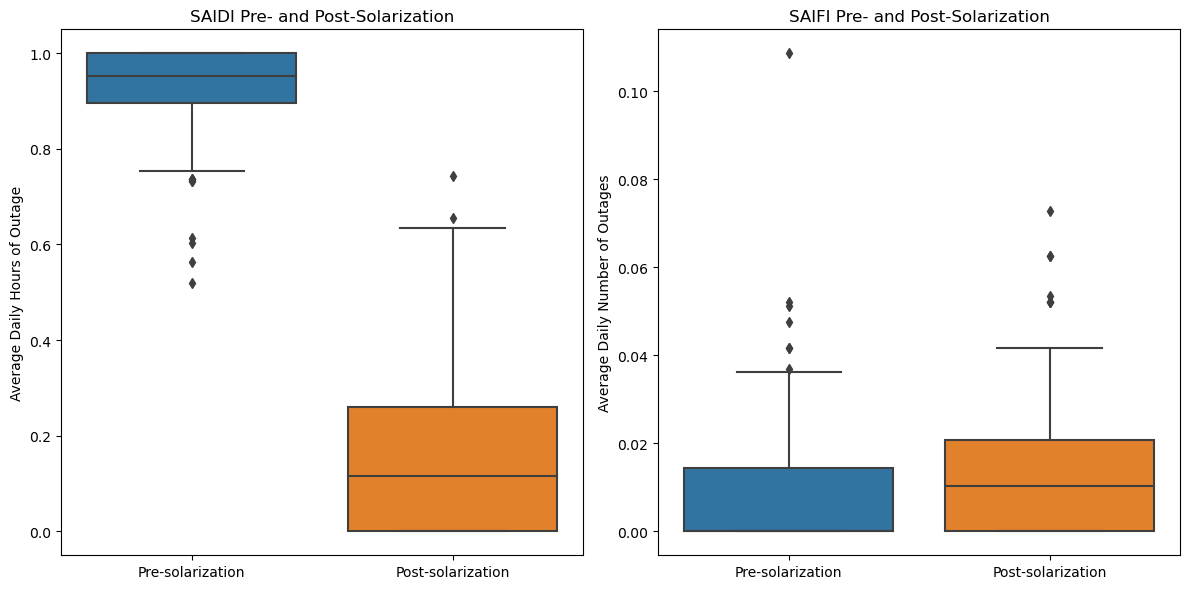

In [23]:
# Box plot for comparison pre- and post-installation
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# SAIDI box plot
sns.boxplot(data=[df_pre['SAIDI'], df_post['SAIDI']], ax=ax[0])
ax[0].set_xticklabels(['Pre-solarization', 'Post-solarization'])
ax[0].set_title('SAIDI Pre- and Post-Solarization')
ax[0].set_ylabel('Average Daily Hours of Outage')

# SAIFI box plot
sns.boxplot(data=[df_pre['SAIFI'], df_post['SAIFI']], ax=ax[1])
ax[1].set_xticklabels(['Pre-solarization', 'Post-solarization'])
ax[1].set_title('SAIFI Pre- and Post-Solarization')
ax[1].set_ylabel('Average Daily Number of Outages')

plt.savefig("images/SAIFI-SAIDI-pre-post-solarization-box-plots.png", dpi=150)

plt.tight_layout()
plt.show()

### 2. Examining Voltage and Load Profile

#### Prepare voltage data

In [24]:
# Import voltage data 
df_averagevoltage = wrangle("data/sierra-leone_voltage_site_id_hour_2023-10-01-to-2024-05-01.csv")
df_averagevoltage.head()

,average_voltage
hour,
2024-01-08 17:00:00+00:00,231.7421
2023-12-17 14:00:00+00:00,232.1546
2024-01-11 00:00:00+00:00,233.4512
2024-02-03 11:00:00+00:00,231.9425
2023-12-10 10:00:00+00:00,232.8619


In [25]:
# Check
assert any([isinstance(df_averagevoltage, pd.DataFrame), isinstance(df_averagevoltage, pd.Series)])
assert isinstance(df_averagevoltage.index, pd.DatetimeIndex)

In [26]:
#Sort index values in descending order
df_averagevoltage.index = df_averagevoltage.index.sort_values()
df_averagevoltage.head()

,average_voltage
hour,
2023-10-01 13:00:00+00:00,231.7421
2023-10-01 14:00:00+00:00,232.1546
2023-10-01 15:00:00+00:00,233.4512
2023-10-01 16:00:00+00:00,231.9425
2023-10-01 17:00:00+00:00,232.8619


In [27]:
#localize time to GMT because load profile data is recorded in GMT
df_averagevoltage.index = df_averagevoltage.index.tz_convert("GMT")

#### Explore voltage data

In [28]:
df_averagevoltage.describe()

,average_voltage
count,3810.000000
mean,231.080668
std,7.077268
min,64.827900
25%,230.800175
50%,231.682350
75%,232.701075
max,249.952900


The data points are spread over a wide range, from a minimum of 64.8279 to a maximum of 249.9529. 
We, therefore, need to test for outliers and remove them. 

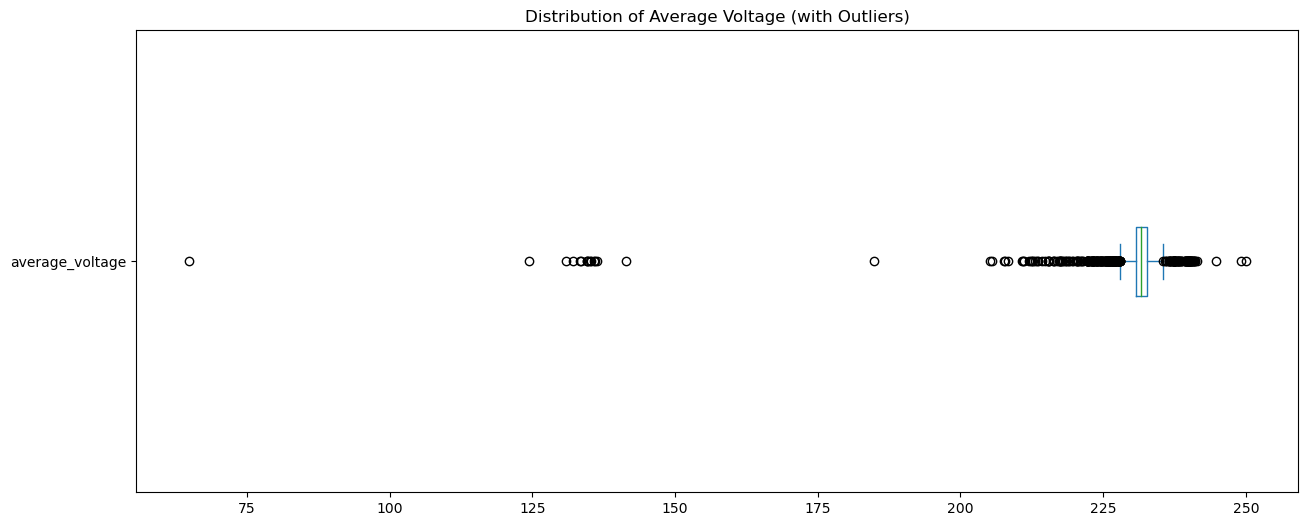

In [29]:
#Create a boxplot to visualize the distribution of the data with possible outliers
fig, ax = plt.subplots(figsize=(15, 6))

df_averagevoltage["average_voltage"].plot(
    kind="box",
    vert=False,
    title="Distribution of Average Voltage (with Outliers)",
    ax=ax);

In [30]:
 #Use mean and standard deviation to remove outliers
mean = df_averagevoltage["average_voltage"].mean()
std = df_averagevoltage["average_voltage"].std()

cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off
df_averagevoltage = df_averagevoltage[
    (df_averagevoltage["average_voltage"] < upper) 
    & (df_averagevoltage["average_voltage"] > lower)
    ]

df_averagevoltage.describe()

,average_voltage
count,3789.000000
mean,231.526856
std,2.598676
min,210.813900
25%,230.818800
50%,231.689100
75%,232.708600
max,249.952900


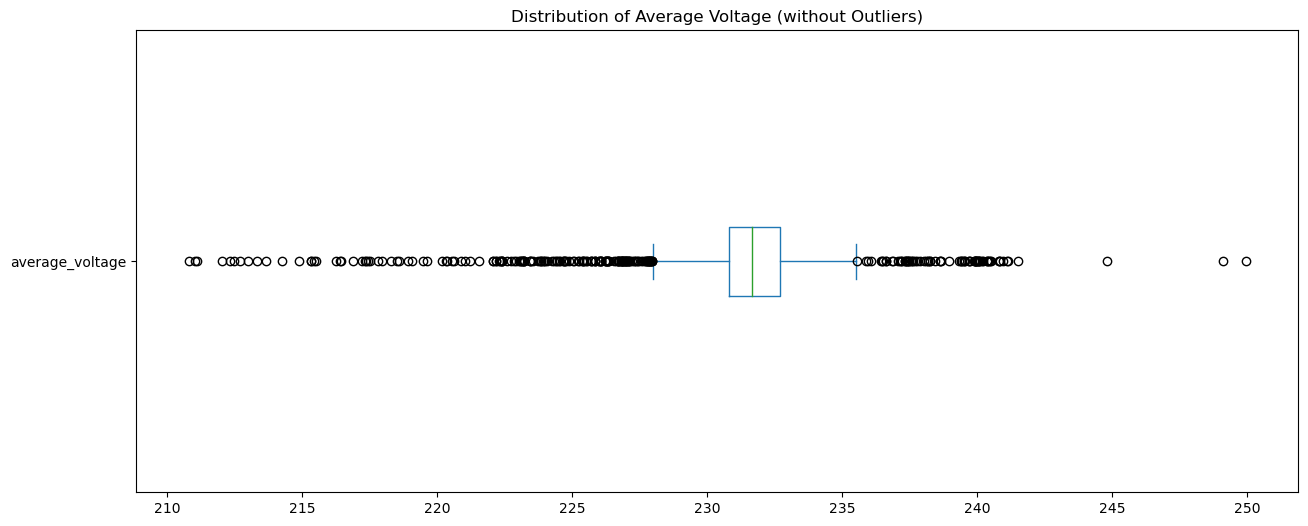

In [31]:
#Create a boxplot to visualize the distribution of the data without outliers
fig, ax = plt.subplots(figsize=(15, 6))

df_averagevoltage["average_voltage"].plot(
    kind="box",
    vert=False,
    title="Distribution of Average Voltage (without Outliers)",
    ax=ax);

#### Visualizing voltage data

In [32]:
# Resample data and fill missing values using ffill
df_averagevoltage_ = df_averagevoltage["average_voltage"].resample("1H").mean().fillna(method="ffill").to_frame()

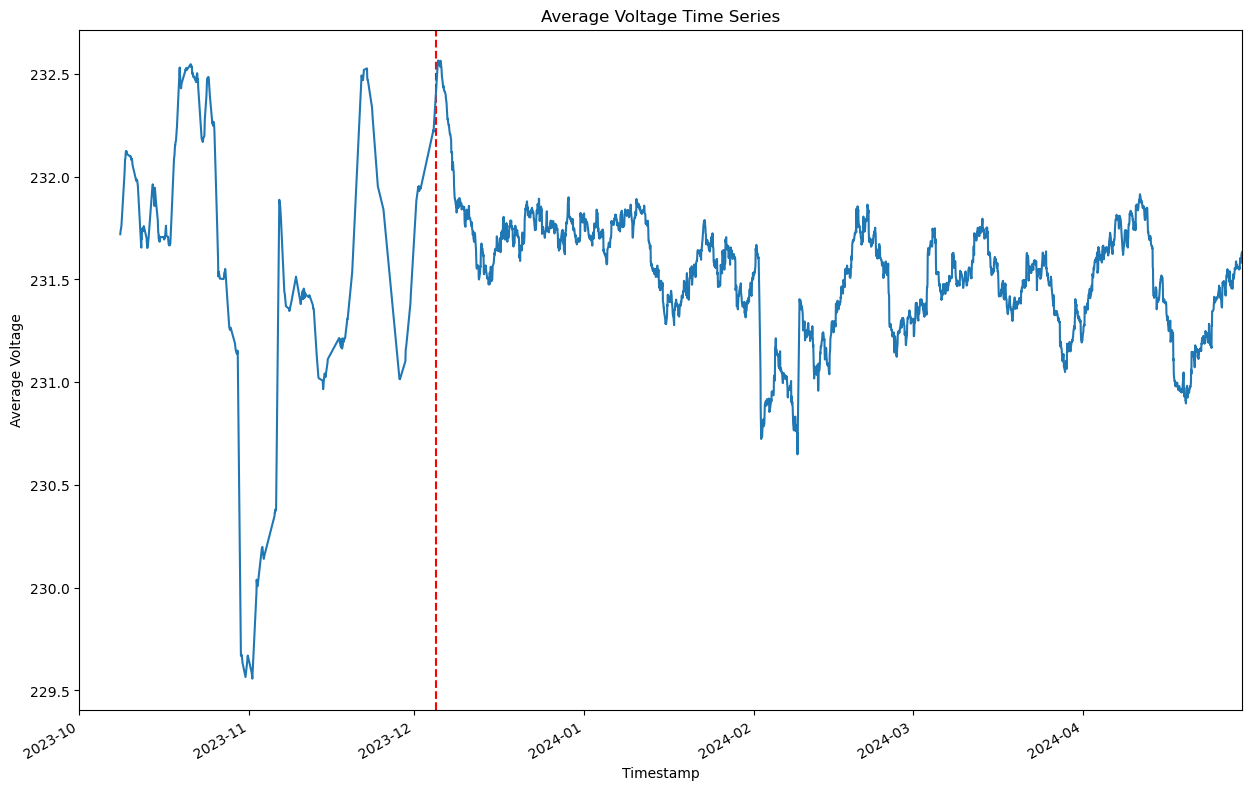

In [33]:
# Plot timeseries plot of average voltage with resampled data

fig, ax = plt.subplots(figsize = (15,10))

ax.set_xlim(df.index.min(), df.index.max())

ax.axvline(
    pd.Timestamp('2023-12-05'), 
    color='red', 
    linestyle='--', 
    label='Solar Installation')

df_averagevoltage_["average_voltage"].rolling(168).mean().plot(
    xlabel="Timestamp", 
    ylabel="Average Voltage", 
    title="Average Voltage Time Series",
    ax=ax);

While the plot above shows some variation between the pre- and post-solarization average voltage patterns, it does not clearly tell what happens within a particular day. This in-day focus is especially important since, as we will see shortly, the load profile data contains 24 entries, representing the load profile of the hospital within a 24-hour period. Thus, to study the average voltage behavior throughout the day, we will use lineplots.


First, we subset the data into three groups representing randomly selected days: October 1, 2023; January 31, 2024; and April 30, 2024. 

In [34]:
# Subset the data for the three specific days
oct_03_2023 = df_averagevoltage.loc['2023-10-03']
jan_31_2024 = df_averagevoltage.loc['2024-01-31']
apr_30_2024 = df_averagevoltage.loc['2024-04-30']

# Add a new column to identify the day
oct_03_2023['day'] = '2023-10-03'
jan_31_2024['day'] = '2024-01-31'
apr_30_2024['day'] = '2024-04-30'

# Combine the subsets into a single DataFrame
df_combined = pd.concat([oct_03_2023, jan_31_2024, apr_30_2024])

# Reset index to get 'hour' as a column for easier plotting
df_combined = df_combined.reset_index()
df_combined['hour'] = df_combined['hour'].dt.hour

df_combined.head()

,hour,average_voltage,day
0,7,231.5712,2023-10-03
1,9,231.6301,2023-10-03
2,10,231.1645,2023-10-03
3,11,231.8187,2023-10-03
4,12,231.9268,2023-10-03


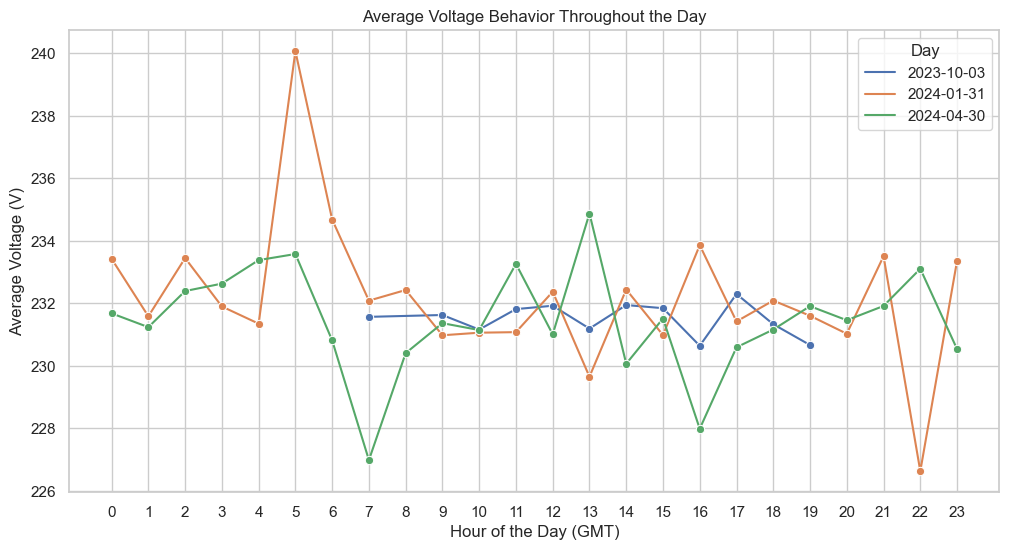

In [35]:
# Plot the data using a lineplot

# Set the style for the plots
sns.set(style="whitegrid")

# Line plot for Average Voltage
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='average_voltage', hue='day', data=df_combined, marker='o')

# Customize the plot
plt.title('Average Voltage Behavior Throughout the Day')
plt.xlabel('Hour of the Day (GMT)')
plt.ylabel('Average Voltage (V)')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='Day')

plt.savefig("images/average-voltage-throughout-the-day.png", dpi=150)

plt.show()

#### Prepare load profile data

In [36]:
# Import load profile data
df_load = pd.read_csv("data/Load Profile-data-bonthe.csv")

In [38]:
df_load.head()

,Hour of the Day (GMT),Upper Bound,Lower Bound,Average Load
0,0,7.61 kW,5.14 kW,6.38 kW
1,1,7.93 kW,6.73 kW,7.33 kW
2,2,7.59 kW,6.53 kW,7.06 kW
3,3,7.25 kW,5.85 kW,6.55 kW
4,4,6.85 kW,5.46 kW,6.16 kW


In [39]:
# Drop columns
df_load.drop(columns = ["Upper Bound", "Lower Bound"], inplace = True)

df_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Hour of the Day (GMT)  24 non-null     int64 
 1   Average Load           24 non-null     object
dtypes: int64(1), object(1)
memory usage: 512.0+ bytes


In [40]:
# Recast kW string to float 

df_load["Average Load"] = df_load["Average Load"].str.replace(' kW', '').astype(float)

df_load.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Hour of the Day (GMT)  24 non-null     int64  
 1   Average Load           24 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 512.0 bytes


#### Explore and visualize load profile data

In [41]:
print(df_load.head())

print()

print(df_load.describe())

   Hour of the Day (GMT)  Average Load
0                      0          6.38
1                      1          7.33
2                      2          7.06
3                      3          6.55
4                      4          6.16

       Hour of the Day (GMT)  Average Load
count              24.000000     24.000000
mean               11.500000      8.013333
std                 7.071068      2.544509
min                 0.000000      4.870000
25%                 5.750000      6.507500
50%                11.500000      6.850000
75%                17.250000      9.542500
max                23.000000     13.500000


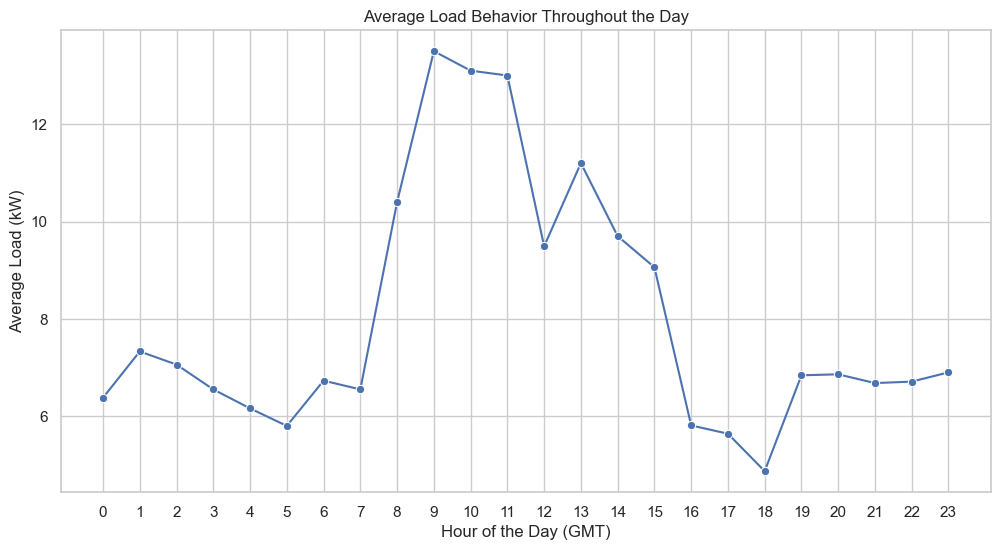

In [42]:
# Line plot for load profile

plt.figure(figsize=(12, 6))
sns.lineplot(x="Hour of the Day (GMT)", y="Average Load", data=df_load, marker='o')
plt.title('Average Load Behavior Throughout the Day')
plt.xlabel('Hour of the Day (GMT)')
plt.ylabel('Average Load (kW)')
plt.xticks(range(0, 24))
plt.grid(True)

plt.savefig("images/average-load-throughout-the-day.png", dpi=150)

plt.show()

### 3. Examining Undervoltage Hours

#### Prepare data

In [43]:
# Import data
df_undervoltage = pd.read_csv("data/sierra-leone_undervolt_site_id_day_2023-10-01-to-2024-05-01.csv")
df_undervoltage.head()

,day,site_id,hours_undervoltage
0,2023-10-01,bonthe,0.0833
1,2023-10-02,bonthe,0.0000
2,2023-10-03,bonthe,0.0833
3,2023-10-04,bonthe,0.0000
4,2023-10-05,bonthe,0.0000


In [44]:
# drop column "site_id"
df_undervoltage.drop(columns="site_id", inplace=True)

# Convert the 'day' column to datetime format
df_undervoltage['day'] = pd.to_datetime(df_undervoltage['day'], format='%Y-%m-%d')

# Set 'day' as the index
df_undervoltage.set_index('day', inplace=True)


df_undervoltage.head()

,hours_undervoltage
day,
2023-10-01,0.0833
2023-10-02,0.0000
2023-10-03,0.0833
2023-10-04,0.0000
2023-10-05,0.0000


#### Explore undervoltage data

In [45]:
df_undervoltage.describe()

,hours_undervoltage
count,198.000000
mean,0.053453
std,0.432183
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,5.166700


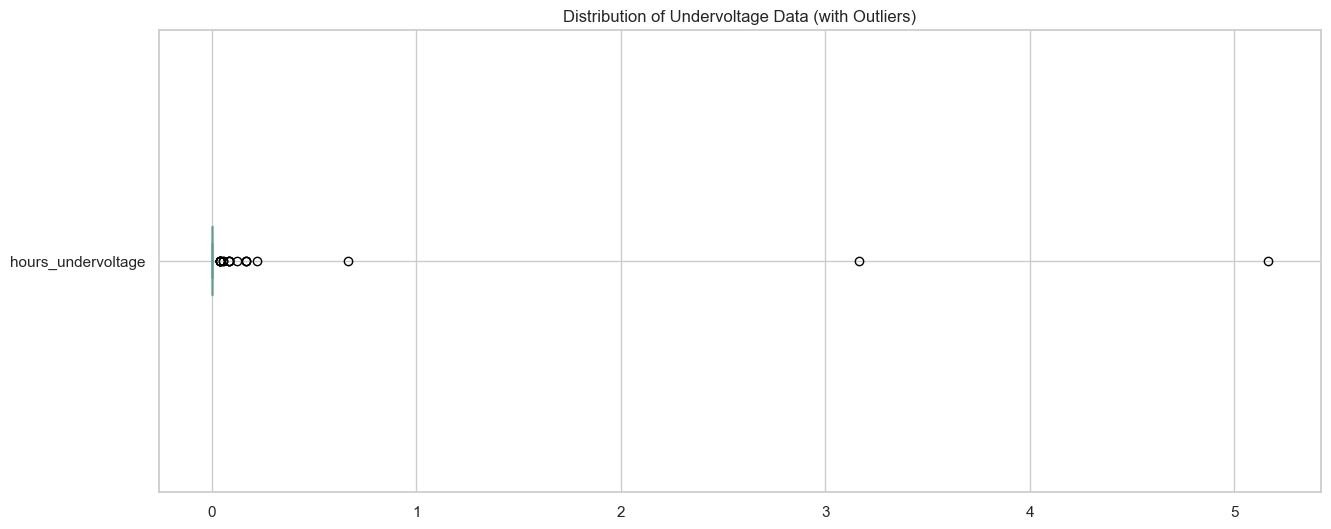

In [46]:
#Create a boxplot to visualize the distribution of undervoltage data to identify outliers
fig, ax = plt.subplots(figsize=(15, 6))

df_undervoltage["hours_undervoltage"].plot(
    kind="box",
    vert=False,
    title="Distribution of Undervoltage Data (with Outliers)",
    ax=ax);

In [47]:
 #Use mean and standard deviation to remove outliers
mean = df_undervoltage["hours_undervoltage"].mean()
std = df_undervoltage["hours_undervoltage"].std()

cut_off = std * 3
lower, upper = mean - cut_off, mean + cut_off
df_undervoltage = df_undervoltage[
    (df_undervoltage["hours_undervoltage"] < upper) 
    & (df_undervoltage["hours_undervoltage"] > lower)]

df_undervoltage.describe()

,hours_undervoltage
count,196.000000
mean,0.011481
std,0.056074
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.666700


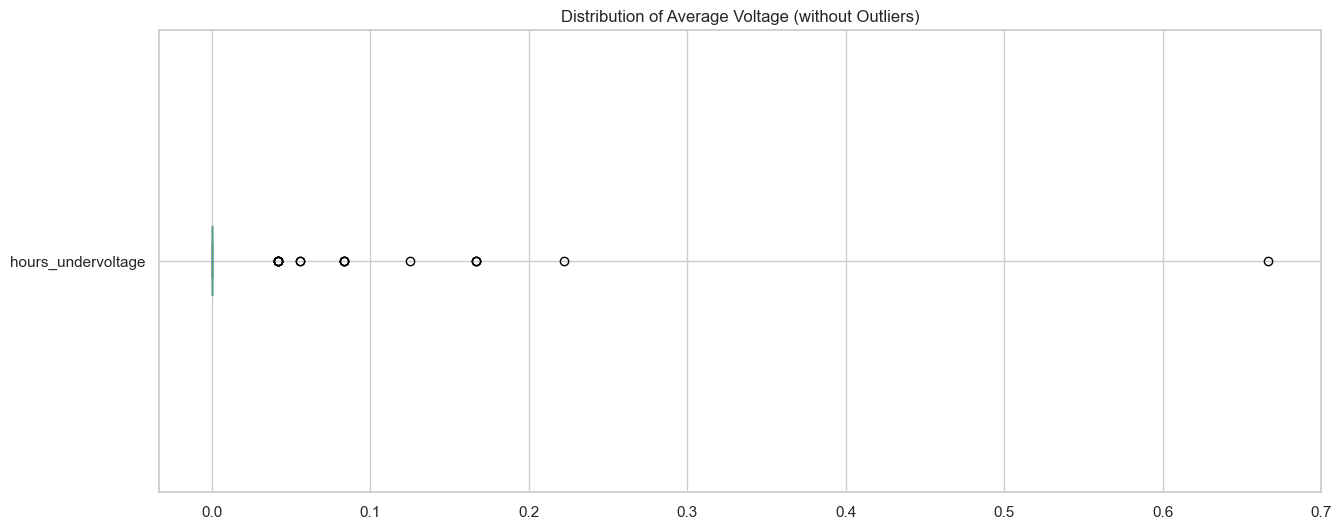

In [48]:
#Create a boxplot to visualize the distribution of undervoltage data without outliers
fig, ax = plt.subplots(figsize=(15, 6))

df_undervoltage["hours_undervoltage"].plot(
    kind="box",
    vert=False,
    title="Distribution of Average Voltage (without Outliers)",
    ax=ax);

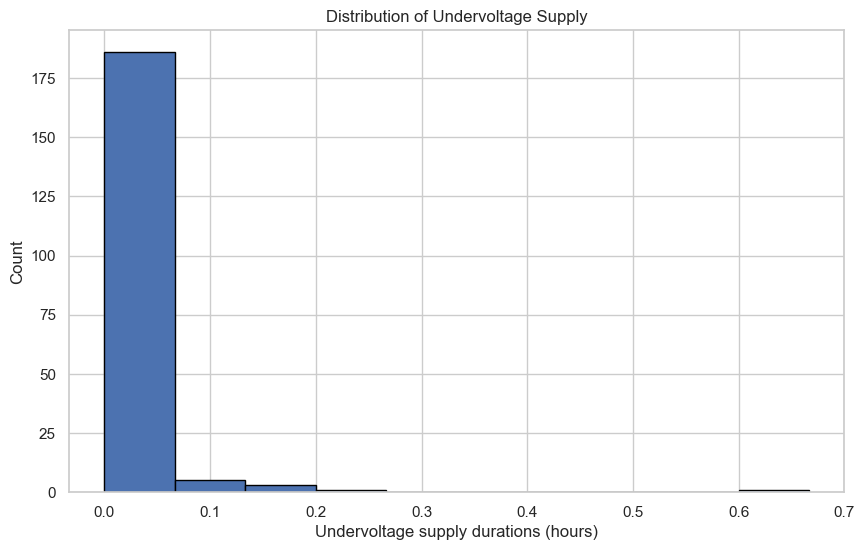

In [49]:
# Histogram plot to show the distribution of undervoltage supply durations
plt.figure(figsize=(10, 6))
plt.hist(df_undervoltage['hours_undervoltage'], bins=10, edgecolor='black')
plt.xlabel('Undervoltage supply durations (hours)')
plt.ylabel('Count')
plt.title('Distribution of Undervoltage Supply')
plt.grid(True)
plt.savefig("images/undervoltage-supply-distribution.png", dpi=150)
plt.show()

In [50]:
# Resample data to monthly time periods
df_undervoltage = df_undervoltage["hours_undervoltage"].resample("1M").mean().to_frame()

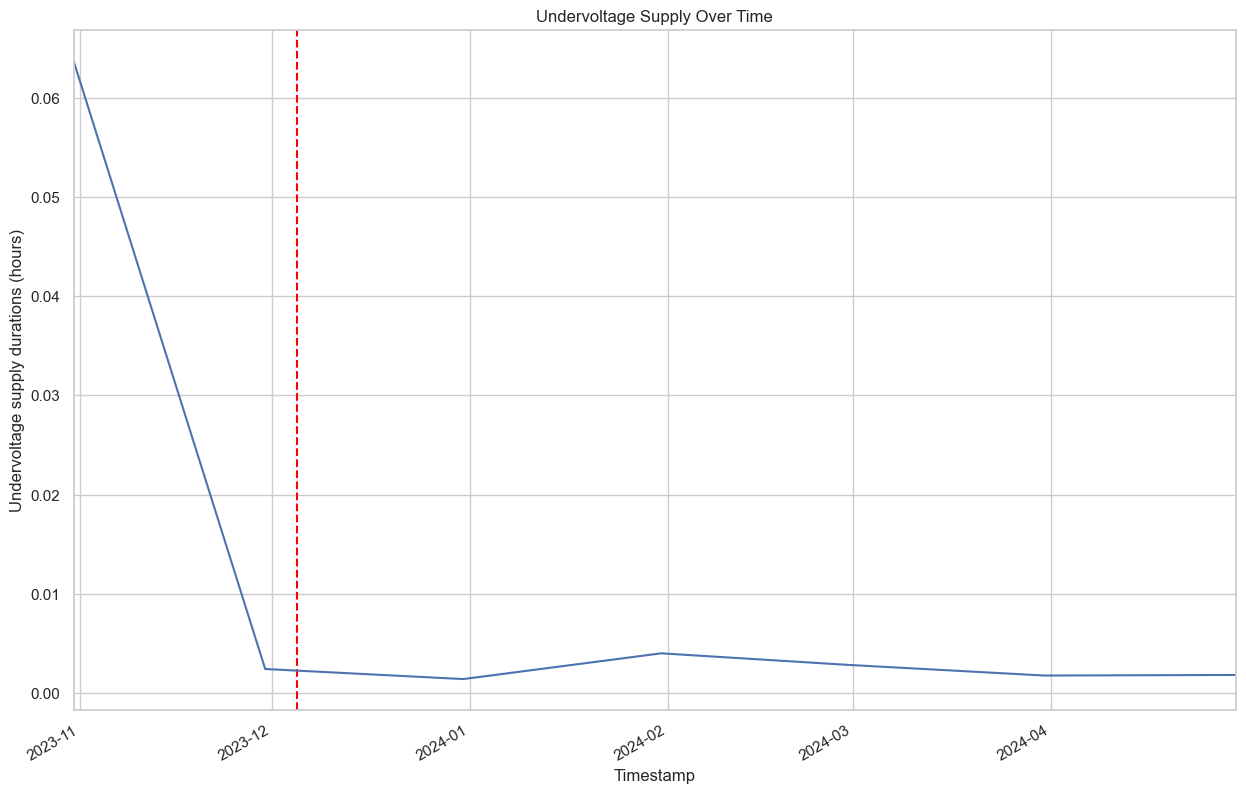

In [51]:
# Plot timeseries of average voltages
fig, ax = plt.subplots(figsize = (15,10))
#Set x-axis limits to the range of the data
ax.set_xlim(df_undervoltage.index.min(), df_undervoltage.index.max())

ax.axvline(
    pd.Timestamp('2023-12-05'), 
    color='red', 
    linestyle='--', 
    label='Solar Installation')

df_undervoltage["hours_undervoltage"].plot(
    xlabel="Timestamp", 
    ylabel="Undervoltage supply durations (hours)", 
    title="Undervoltage Supply Over Time",
    ax=ax);

plt.savefig("images/hours-undervoltage-time-series.png", dpi=150)